# Music Composer Classification using Neural Network

# Team members:
1. Suman Senapati
2. Navyesh
3. Shruti A K

## Additional Libraries

In [1]:
!pip install tensorflow music21

## Libraries

In [2]:
# For data handling and visualizations
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
from collections import Counter

# For data pre-processing
import os
import glob
from music21 import converter, instrument, note, chord

# For neural network building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import AUC
from sklearn.metrics import classification_report, f1_score
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

# For model weights saving
import pickle

2025-08-02 05:04:21.011382: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754111061.198318      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754111061.254665      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Configuration

In [3]:
warnings.filterwarnings('ignore')

## Dataset

#### Function to parse MIDI files and extract notes, chords and rests.

In [4]:
def get_notes_from_midi(file_path):
    notes = []
    try:
        midi = converter.parse(file_path)
        notes_to_parse = None

        # Assuming the music could be in different parts (instruments)
        parts = instrument.partitionByInstrument(midi)
        if parts:
            notes_to_parse = parts.parts[0].recurse()
        else:
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))
            elif isinstance(element, note.Rest):
                notes.append('rest')
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
    return notes

#### Loads all MIDI files from the specified directory structure

In [5]:
def load_midi_files(path):
    composers = {}
    for composer_dir in os.listdir(path):
        composer_path = os.path.join(path, composer_dir)
        if os.path.isdir(composer_path):
            print(f"Loading files for {composer_dir}...")
            all_notes = []
            # Using glob to find all .mid and .midi files
            for file in glob.glob(os.path.join(composer_path, '*.mid*')):
                notes = get_notes_from_midi(file)
                if notes:
                    all_notes.extend(notes)
            composers[composer_dir] = all_notes
    return composers

## Data Preparation

#### Creates input sequences and corresponding outputs for the network.

In [6]:
def prepare_sequences(all_notes, note_to_int, sequence_length=100):
    network_input = []
    network_output = []
    
    for i in range(0, len(all_notes) - sequence_length, 1):
        sequence_in = all_notes[i:i + sequence_length]
        sequence_out = all_notes[i + sequence_length]

        if all(item in note_to_int for item in sequence_in) and sequence_out in note_to_int:
            network_input.append([note_to_int[char] for char in sequence_in])
            network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)
    if n_patterns == 0:
        # Return empty arrays if no valid sequences could be made
        return np.array([]), np.array([])
        
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    
    network_input = network_input / float(len(note_to_int))
    
    return network_input, network_output

In [7]:
base_path='/kaggle/input/composer-dataset/Composer_Dataset/NN_midi_files_extended'
train_path = os.path.join(base_path, 'train')
dev_path = os.path.join(base_path, 'dev')
test_path = os.path.join(base_path, 'test')

In [8]:
train_composers_notes = load_midi_files(train_path)
dev_composers_notes = load_midi_files(dev_path)

Loading files for hummel...
Loading files for bartok...
Loading files for handel...
Loading files for byrd...
Loading files for bach...
Loading files for mozart...
Loading files for schumann...
Loading files for mendelssohn...
Loading files for chopin...
Loading files for hummel...
Loading files for bartok...
Loading files for handel...
Loading files for byrd...
Loading files for bach...
Loading files for mozart...
Loading files for schumann...
Loading files for mendelssohn...
Loading files for chopin...


In [9]:
all_notes = []
composer_labels = []

#### Combined dataset for preparing sequences

In [10]:
combined_notes = {}
for composer, notes in train_composers_notes.items():
    if composer not in combined_notes:
        combined_notes[composer] = []
    combined_notes[composer].extend(notes)
    
for composer, notes in dev_composers_notes.items():
    if composer not in combined_notes:
        combined_notes[composer] = []
    combined_notes[composer].extend(notes)

#### Vocabulatory creation

In [11]:
pitchnames = sorted(set(item for notes in combined_notes.values() for item in notes))
n_vocab = len(pitchnames)
note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

print(f"\nVocabulary size: {n_vocab}")


Vocabulary size: 1155


#### Preparation of training and validation data

In [12]:
all_network_input = []
all_network_output = []

#### Mapping composers to integers

In [13]:
composer_list = sorted(combined_notes.keys())
composer_to_int = {name: i for i, name in enumerate(composer_list)}
n_composers = len(composer_list)
    
print(f"Found {n_composers} composers: {composer_list}")

for composer, notes in combined_notes.items():
        if len(notes) > 100:
            input_seq, _ = prepare_sequences(notes, note_to_int)
            output_label = [composer_to_int[composer]] * len(input_seq)
            
            all_network_input.extend(input_seq)
            all_network_output.extend(output_label)

Found 9 composers: ['bach', 'bartok', 'byrd', 'chopin', 'handel', 'hummel', 'mendelssohn', 'mozart', 'schumann']


In [14]:
X = np.array(all_network_input)
y = np.array(all_network_output)

#### One-hot encoding of labels

In [15]:
y = to_categorical(y, num_classes=n_composers)

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (527078, 100, 1)
Validation data shape: (131770, 100, 1)


## Data Visualizations

#### Counting number of MIDI files for each composer in a given directory

In [17]:
def get_composer_counts(path):
    composer_counts = {}
    for composer_dir in os.listdir(path):
        composer_path = os.path.join(path, composer_dir)
        if os.path.isdir(composer_path):
            # Count .mid and .midi files
            file_count = len(glob.glob(os.path.join(composer_path, '*.mid*')))
            composer_counts[composer_dir] = file_count
    return composer_counts

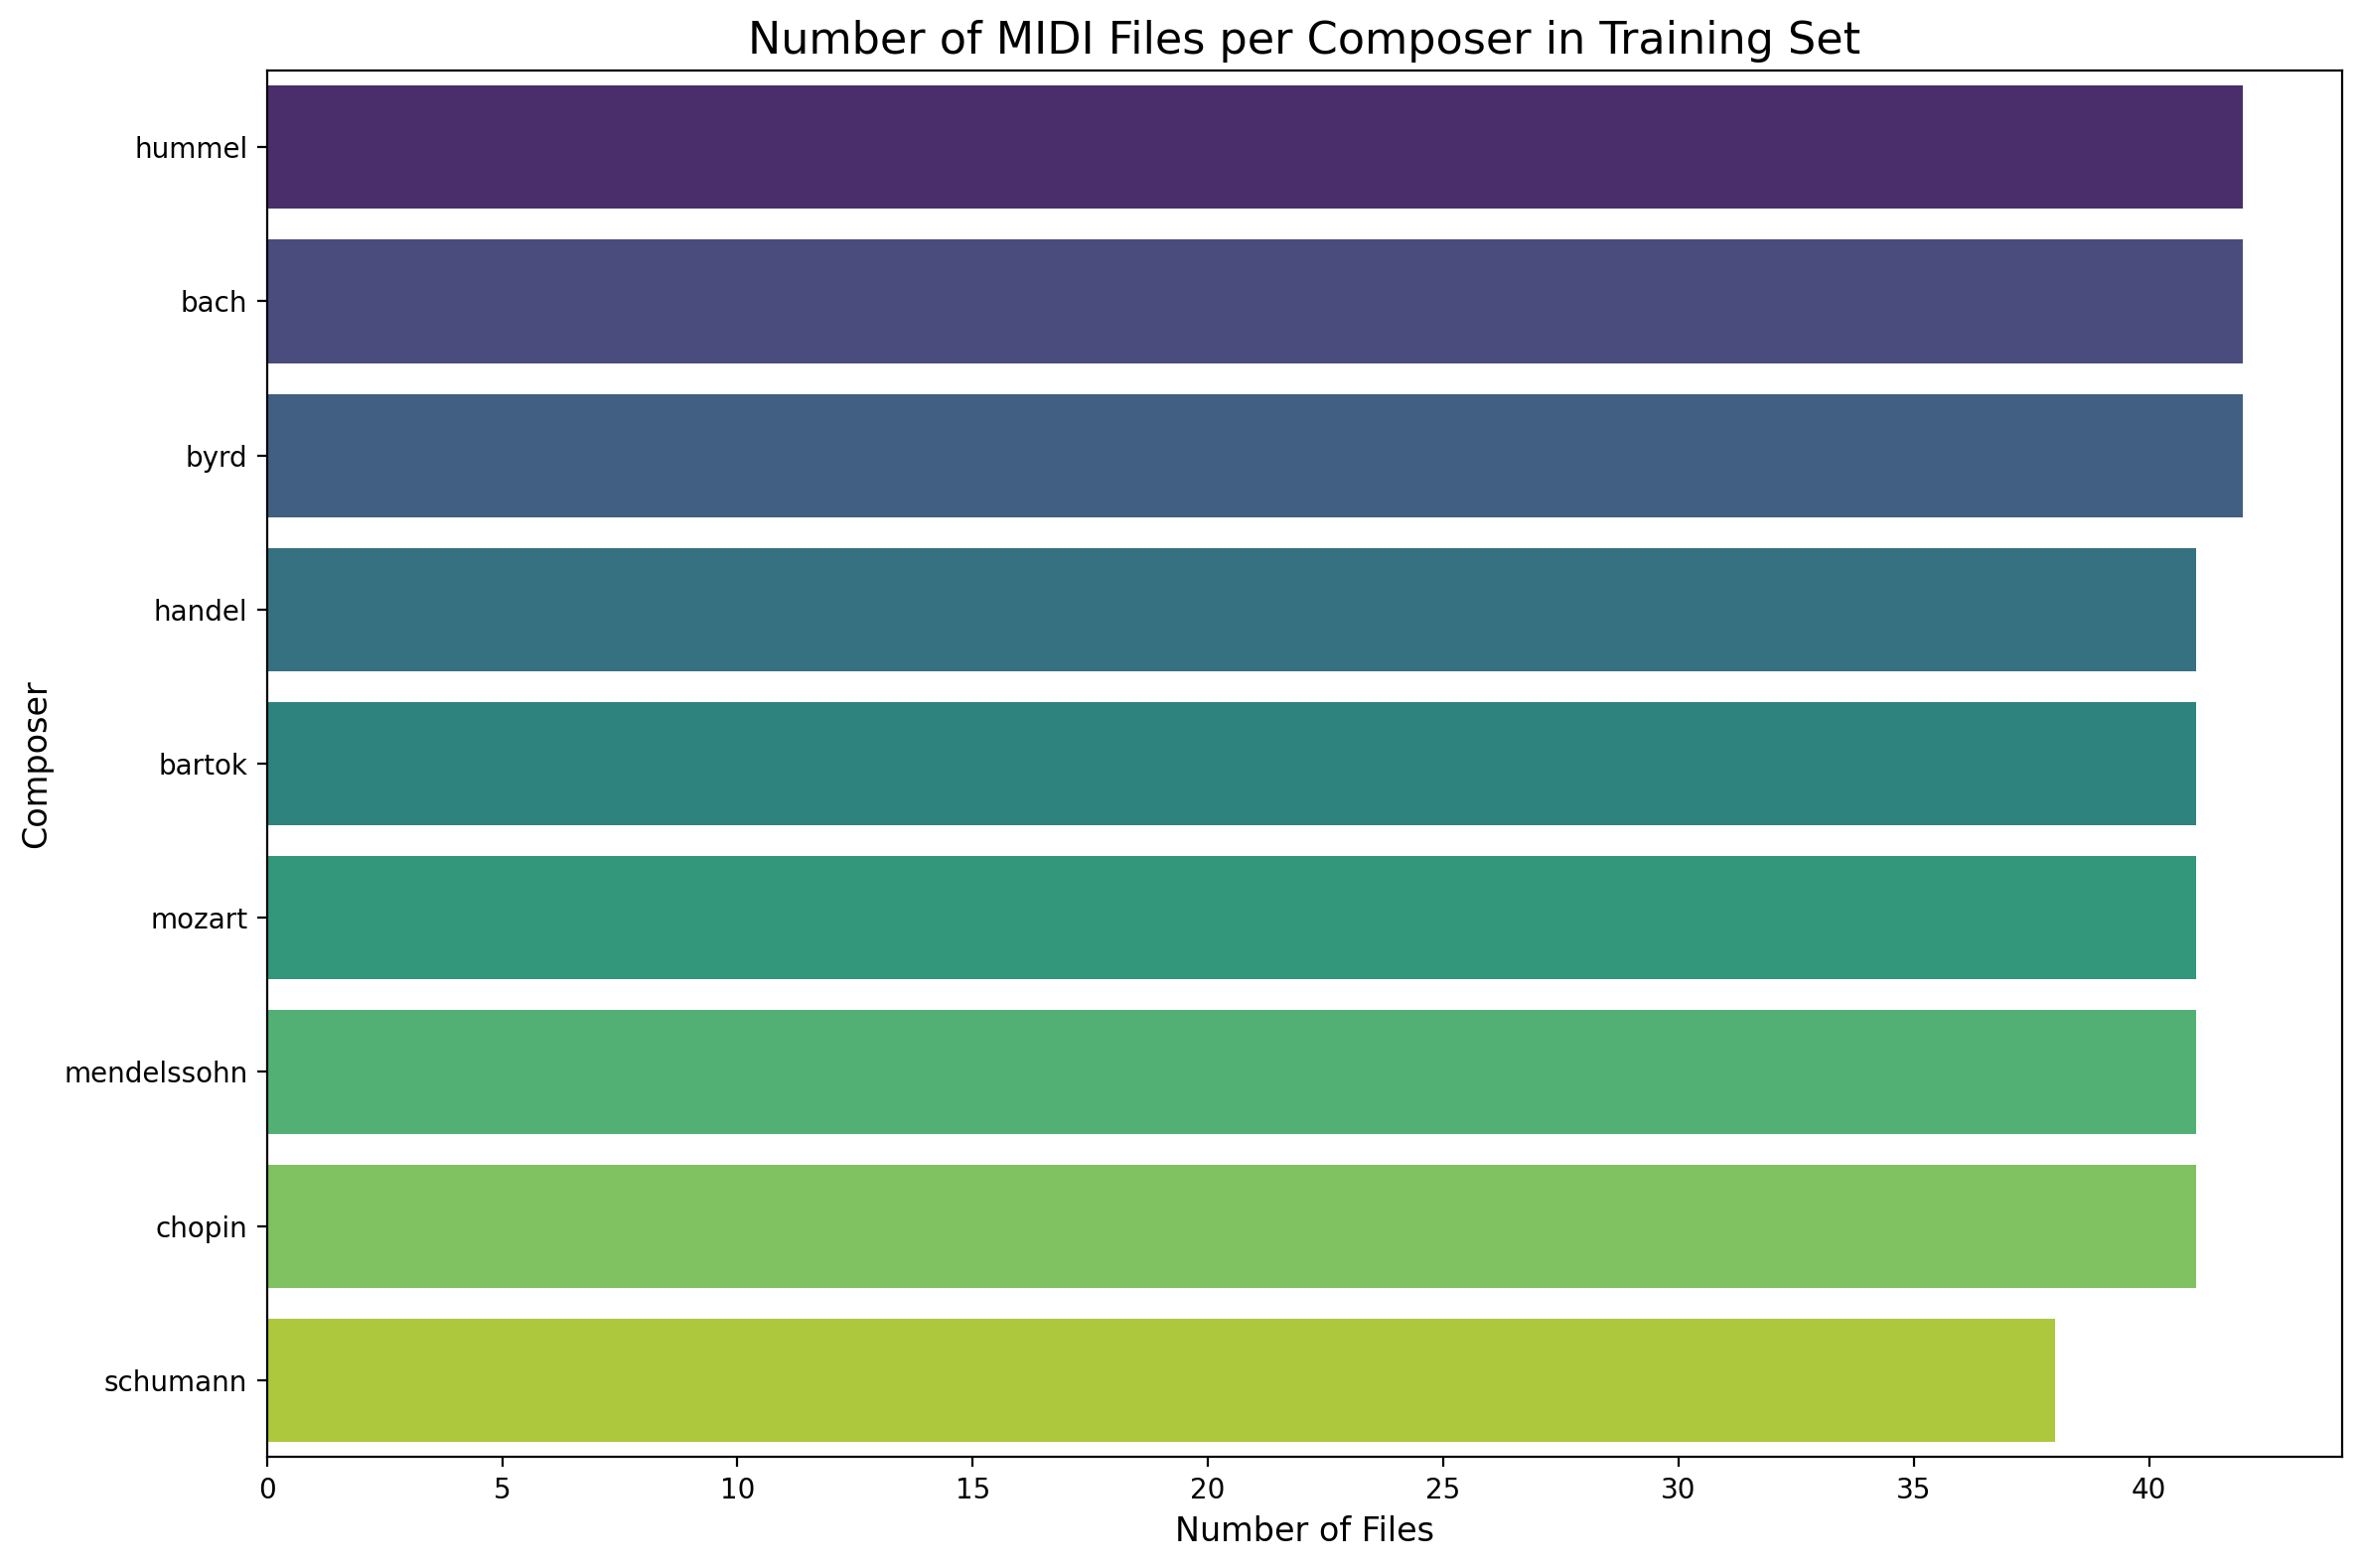

In [18]:
train_counts = get_composer_counts(train_path)
df_counts = pd.DataFrame(list(train_counts.items()), columns=['Composer', 'File Count'])
df_counts = df_counts.sort_values('File Count', ascending=False)

plt.figure(figsize=(12, 8))
sn.barplot(x='File Count', y='Composer', data=df_counts, palette='viridis', orient='h')
plt.title('Number of MIDI Files per Composer in Training Set', fontsize=16)
plt.xlabel('Number of Files', fontsize=12)
plt.ylabel('Composer', fontsize=12)
plt.tight_layout()
plt.show()

#### Note & Chord Distribution

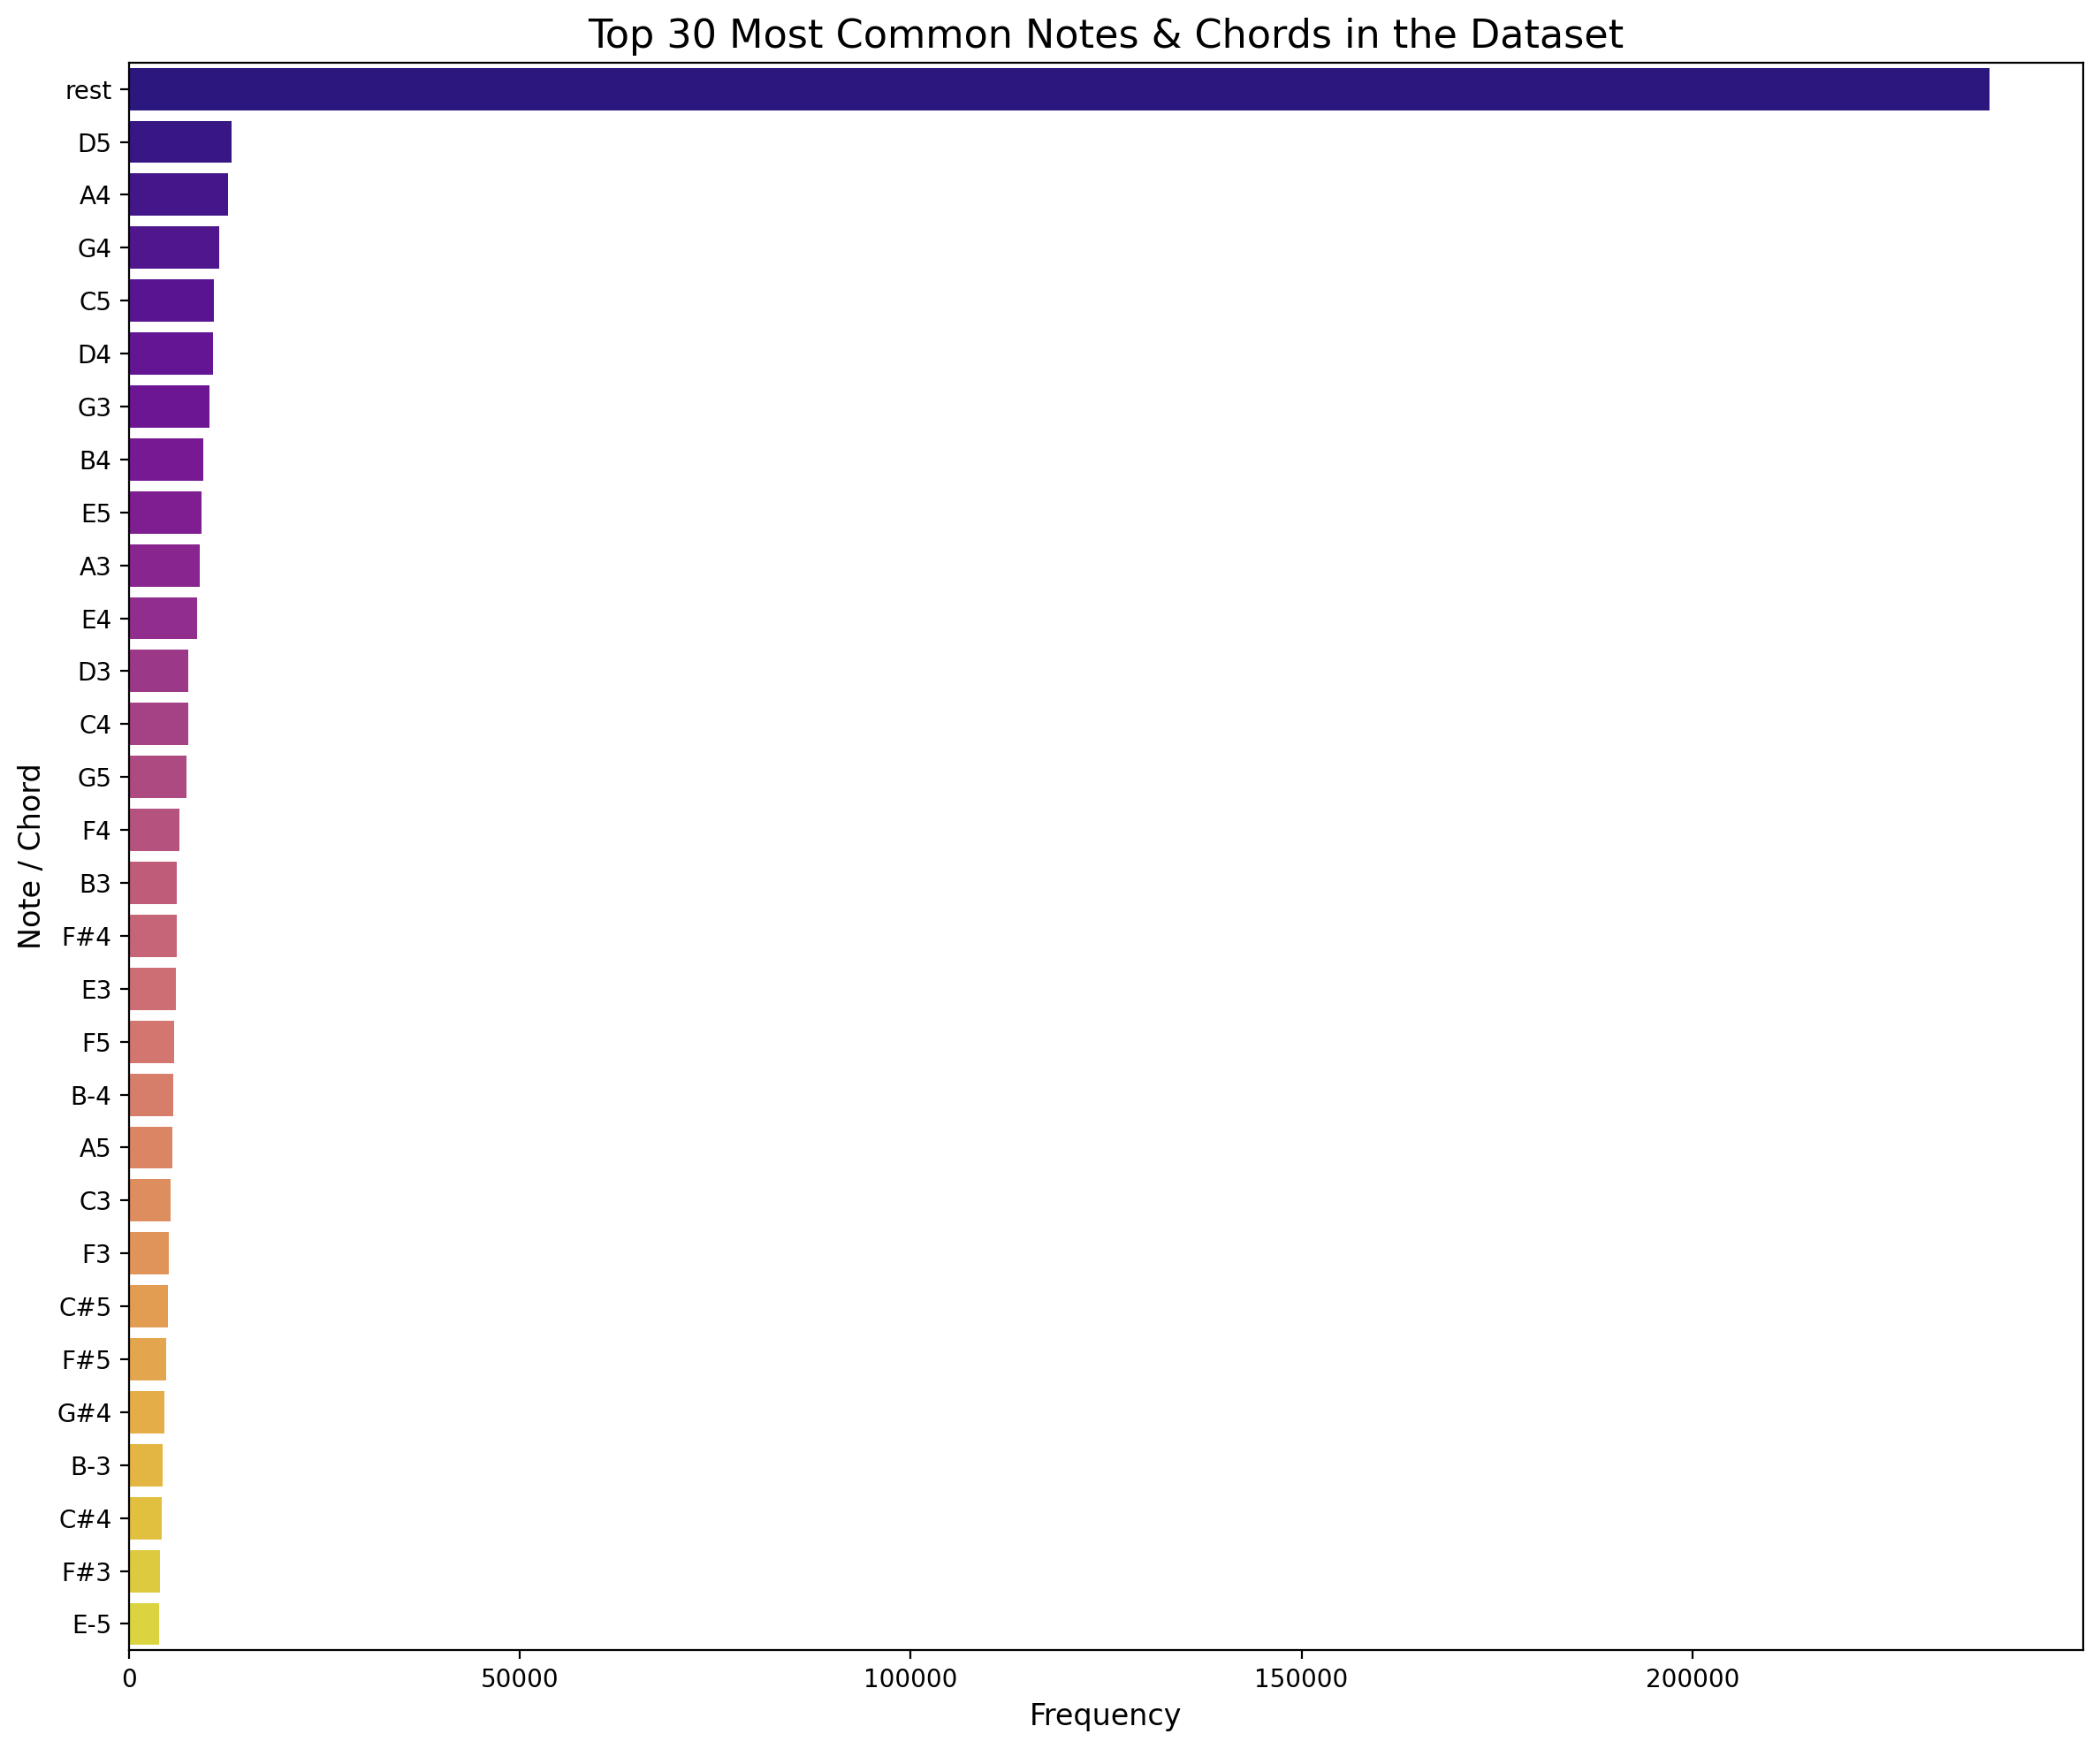

In [19]:
all_elements = [element for notes_list in combined_notes.values() for element in notes_list]

element_counts = Counter(all_elements)
most_common_elements = element_counts.most_common(30)
df_elements = pd.DataFrame(most_common_elements, columns=['Element', 'Count'])

plt.figure(figsize=(12, 10))
sn.barplot(x='Count', y='Element', data=df_elements, palette='plasma', orient='h')
plt.title('Top 30 Most Common Notes & Chords in the Dataset', fontsize=16)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Note / Chord', fontsize=12)
plt.tight_layout()
plt.show()

#### Distribution of Musical Piece Lengths

## Model Building

In [20]:
model = Sequential()

In [21]:
model.add(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_regularizer=regularizers.l2(0.001), padding='causal',
                    input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.4))

model.add(LSTM(256, return_sequences=True, kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))

model.add(LSTM(256, kernel_regularizer=regularizers.l2(0.001)))

model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(n_composers, activation='softmax'))

I0000 00:00:1754113284.244165      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


#### Model compilation

In [22]:
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=[AUC(name='roc_auc')])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 100, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50, 256)        │       328,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 256)            │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 922,505 (3.52 MB)

 Trainable params: 922,505 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

## Model Training

In [23]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [24]:
history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=128,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping]
    )

Epoch 1/30


I0000 00:00:1754113289.984901      68 cuda_dnn.cc:529] Loaded cuDNN version 90300


4118/4118 ━━━━━━━━━━━━━━━━━━━━ 90s 20ms/step - loss: 2.0091 - roc_auc: 0.7365 - val_loss: 1.8558 - val_roc_auc: 0.7644
Epoch 2/30
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - loss: 1.8303 - roc_auc: 0.7723 - val_loss: 1.7505 - val_roc_auc: 0.7973
Epoch 3/30
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - loss: 1.7822 - roc_auc: 0.7887 - val_loss: 1.7075 - val_roc_auc: 0.8113
Epoch 4/30
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - loss: 1.7532 - roc_auc: 0.7982 - val_loss: 1.6820 - val_roc_auc: 0.8201
Epoch 5/30
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - loss: 1.7083 - roc_auc: 0.8116 - val_loss: 1.6462 - val_roc_auc: 0.8292
Epoch 6/30
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - loss: 1.6623 - roc_auc: 0.8242 - val_loss: 1.5700 - val_roc_auc: 0.8473
Epoch 7/30
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - loss: 1.6106 - roc_auc: 0.8378 - val_loss: 1.5656 - val_roc_auc: 0.8491
Epoch 8/30
4118/4118 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - loss: 1.5448 - roc_auc: 0.8542 - val_loss: 

## Model Evaluation

In [25]:
test_composers_notes = load_midi_files(test_path)
test_network_input = []
test_network_output = []

Loading files for hummel...
Loading files for bartok...
Loading files for handel...
Loading files for byrd...
Loading files for bach...
Loading files for mozart...
Loading files for schumann...
Loading files for mendelssohn...
Loading files for chopin...


In [26]:
for composer, notes in test_composers_notes.items():
        if composer in composer_to_int and len(notes) > 100:
            input_seq, _ = prepare_sequences(notes, note_to_int)
            output_label = [composer_to_int[composer]] * len(input_seq)
            test_network_input.extend(input_seq)
            test_network_output.extend(output_label)

In [27]:
X_test = np.array(test_network_input)
y_test = np.array(test_network_output)

In [28]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

y_test_labels = y_test

target_names = [name for name, num in sorted(composer_to_int.items(), key=lambda item: item[1])]

weighted_f1 = f1_score(y_test_labels, y_pred, average='weighted')
print(f"\nWeighted F1-Score: {weighted_f1:.4f}")

print("\nDetailed Classification Report:")
print(classification_report(y_test_labels, y_pred, target_names=target_names))

2080/2080 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step

Weighted F1-Score: 0.3476

Detailed Classification Report:
              precision    recall  f1-score   support

        bach       0.40      0.54      0.46     15723
      bartok       0.29      0.12      0.17      4195
        byrd       0.39      0.48      0.43      7208
      chopin       0.20      0.18      0.19      8347
      handel       0.13      0.27      0.17       450
      hummel       0.53      0.39      0.45     20805
 mendelssohn       0.03      0.06      0.04      1202
      mozart       0.31      0.08      0.13      6414
    schumann       0.06      0.18      0.09      2186

    accuracy                           0.35     66530
   macro avg       0.26      0.26      0.24     66530
weighted avg       0.38      0.35      0.35     66530



## Saving Model weights

In [29]:
model.save('composer_classification_model.h5')
    
with open('mappings.pkl', 'wb') as f:
    pickle.dump({'note_to_int': note_to_int, 'composer_to_int': composer_to_int}, f)
        
print("Save completed")

Save completed
